# Deep Image Prior (DIP) for PAM - Batch Mode Only
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from build_unet import *
from utils import *
from keras.optimizers import Adam
import os
from os.path import isfile, join
from numba import cuda
from keras.models import load_model
import scipy.io as sio

Using TensorFlow backend.


In [2]:
""" Choose which gpu to run the training """
gpu = 1  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Step 1: Mode Selection

In [3]:
BATCH_MODE = False  # Run DIP on a set of data for evaluation
WHOLEIMG_MODE = True   # Run DIP on the whole image with 300x300 subimgs

SAVE_MODEL = True  # Save trained model and input noise
SAVE_LOSS = True
SAVE_OUTPUT = True  # Save auxillary info (training time and noise reg) output image, 
                    # with corrected image in the 2nd channel

### Step 2: Params Input and Pre-processing

In [4]:
if BATCH_MODE:
    imgpath = './Data/10_5/'
    start_count = 1
    batch_range = 50
#     batch_range = 1
    list_dir = os.listdir(imgpath)
    list_file = [f for f in list_dir if isfile(join(imgpath, f))]
    prefix, suffix = list_file[0].split('.')
    print(suffix)

In [5]:
# if WHOLEIMG_MODE:
#     IMG_SIZE = 260
#     imgpath = './Data/'
#     imgname = 'brain_xiaoyi_12_6'
#     imgsuffix = 'png'
#     im_all = cv2.imread(imgpath + imgname + '.' + imgsuffix)
#     print(im_all.shape)

#     if im_all.shape[0] % IMG_SIZE != 0:
#         num_x = im_all.shape[0]//IMG_SIZE
#         dim_x = (num_x+1)*IMG_SIZE
#     else:
#         num_x = im_all.shape[0]//IMG_SIZE
#         dim_x = im_all.shape[0]
#     if im_all.shape[1] % IMG_SIZE != 0:
#         num_y = im_all.shape[1]//IMG_SIZE
#         dim_y = (num_y+1)*IMG_SIZE
#     else:
#         num_y = im_all.shape[1]//IMG_SIZE
#         dim_y = im_all.shape[1]

#     im_all_zero = np.zeros((dim_x, dim_y, im_all.shape[2]), dtype=np.uint8)
#     im_all_zero[:im_all.shape[0], :im_all.shape[1], :] = im_all
# #     im_all = im_all[:dim_x, :dim_y, :]
#     im_all = np.copy(im_all_zero)
#     im_out = np.zeros((im_all.shape[0], im_all.shape[1]))
#     im_down_out = np.copy(im_out)
#     im_all = np.pad(im_all, ((20, 20), (20, 20), (0,0)), 'constant')  # zero pad 20x20 along axis 0 and 1
    
# #     fig = plt.figure(figsize=(100, 100))
# #     plt.imshow(im_all[:, :, 1])
# #     plt.show()

#     lin_x = np.arange(150, im_all.shape[1], 260)
#     lin_y = np.arange(150, im_all.shape[0], 260)
#     total_count = len(lin_x)*len(lin_y)
#     print(total_count)
    
#     count = 1
#     for i in lin_x:
#         for j in lin_y:
#             print(count)
#             im_temp = im_all[j-150:j+150, i-150:i+150, :]
#             im, im_gt, im_masked, im_mask, im_down, factor, _, _ = readImg(im_temp)
#             if count == 1:
#                 show_output = True
#             else:
#                 show_output = False
#             [sr_image, l, model, 
#              totalTrainingTimeHr, 
#              input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000, 
#                      noise_reg=0.07, show_output=show_output)
#             tmp = np.squeeze(sr_image)
#             im_out[j-150:j+110, i-150:i+110] = tmp[20:280, 20:280]
#             im_down_out[j-150:j+110, i-150:i+110] = im_down[20:280, 20:280]
#             count += 1
            
#             if SAVE_OUTPUT:
#                 model.save(imgpath + '/output_brain_xiaoyi/' + imgname + str(i) + str(j) + '.h5')
#                 inputNoise = np.squeeze(input_noise)
#                 inputNoise = inputNoise.reshape((inputNoise.shape[0], inputNoise.shape[1]*inputNoise.shape[2]))
#                 np.savetxt(imgpath + '/output_brain_xiaoyi/' + imgname + '_inputNoise' + str(i) + str(j) + '.txt', 
#                            np.asarray(np.squeeze(inputNoise)))

(2676, 3306, 3)
16
1
2
3
4
5
6
7
8
9
10


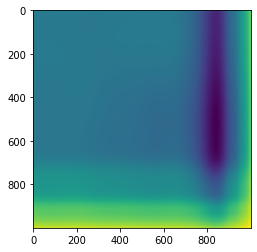

0
0.006331109291493747


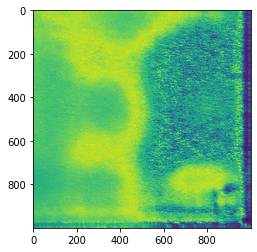

500
0.0001798169395013472


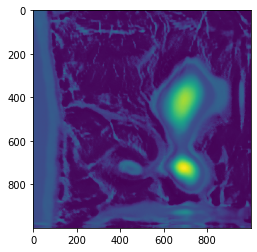

1000
0.07438178500581161


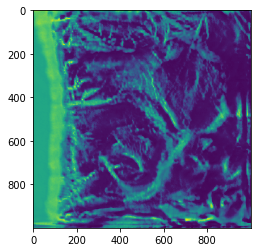

1500
0.0190161227676018


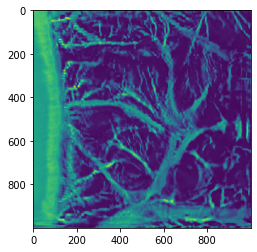

2000
0.017659404708106563


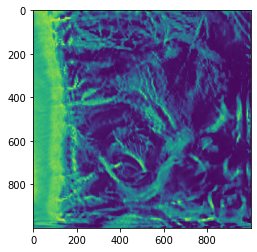

2500
0.013158501494292167


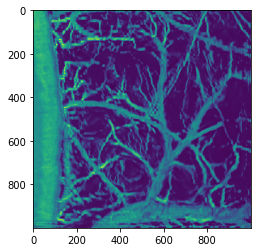

3000
0.025120226938790683


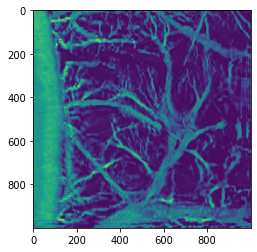

3500
0.016030930468382283


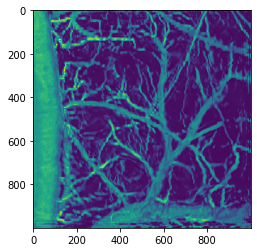

4000
0.01876627330700636


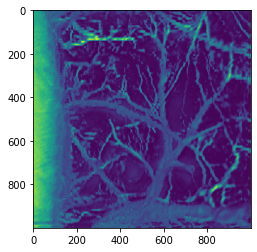

4500
0.043936408869833375
11
12
13
14
15
16


In [26]:
if WHOLEIMG_MODE:
    TRUE_SIZE = 1000
    PAD_SIZE = 70  # Each size
    IMG_SIZE = TRUE_SIZE - round(PAD_SIZE*2)
    imgpath = './Data/'
    imgname = 'brain_xiaoyi_12_6'
    imgsuffix = 'png'
    im_all = cv2.imread(imgpath + imgname + '.' + imgsuffix)
    print(im_all.shape)

    if im_all.shape[0] % IMG_SIZE != 0:
        num_x = im_all.shape[0]//IMG_SIZE
        dim_x = (num_x+1)*IMG_SIZE
    else:
        num_x = im_all.shape[0]//IMG_SIZE
        dim_x = im_all.shape[0]
    if im_all.shape[1] % IMG_SIZE != 0:
        num_y = im_all.shape[1]//IMG_SIZE
        dim_y = (num_y+1)*IMG_SIZE
    else:
        num_y = im_all.shape[1]//IMG_SIZE
        dim_y = im_all.shape[1]

    im_all_zero = np.zeros((dim_x, dim_y, im_all.shape[2]), dtype=np.uint8)
    im_all_zero[:im_all.shape[0], :im_all.shape[1], :] = im_all
#     im_all = im_all[:dim_x, :dim_y, :]
    im_all = np.copy(im_all_zero)
    im_out = np.zeros((im_all.shape[0], im_all.shape[1]))
    im_down_out = np.copy(im_out)
    im_all = np.pad(im_all, ((PAD_SIZE, PAD_SIZE), (PAD_SIZE, PAD_SIZE), (0,0)), 'constant')  # zero pad 20x20 along axis 0 and 1
    
#     fig = plt.figure(figsize=(100, 100))
#     plt.imshow(im_all[:, :, 1])
#     plt.show()

    lin_x = np.arange(round(TRUE_SIZE/2), im_all.shape[1], IMG_SIZE)
    lin_y = np.arange(round(TRUE_SIZE/2), im_all.shape[0], IMG_SIZE)
    total_count = len(lin_x)*len(lin_y)
    print(total_count)
    
    count = 1
    for i in lin_x:
        for j in lin_y:
            print(count)
            if count != 10:
                count += 1
                continue
            im_temp = im_all[j-round(TRUE_SIZE/2):j+round(TRUE_SIZE/2), i-round(TRUE_SIZE/2):i+round(TRUE_SIZE/2), :]
            im, im_gt, im_masked, im_mask, im_down, factor, _, _ = readImg(im_temp)
            if count == 10:
                show_output = True
            else:
                show_output = False
            if count % 4 == 0:
                [sr_image, l, model, 
                 totalTrainingTimeHr, 
                 input_noise, base_model] = train_dp(im_masked, im_gt, im_mask, iter=1, 
                         noise_reg=0.07, show_output=show_output)
            else:
                [sr_image, l, model, 
                 totalTrainingTimeHr, 
                 input_noise, base_model] = train_dp(im_masked, im_gt, im_mask, iter=5000, 
                         noise_reg=0.07, show_output=show_output)
            tmp = np.squeeze(sr_image)
            im_out[j-round(TRUE_SIZE/2):j+round(TRUE_SIZE/2-PAD_SIZE*2), i-round(TRUE_SIZE/2):
                   i+round(TRUE_SIZE/2-PAD_SIZE*2)] = tmp[PAD_SIZE:TRUE_SIZE-PAD_SIZE, PAD_SIZE:TRUE_SIZE-PAD_SIZE]
            im_down_out[j-round(TRUE_SIZE/2):j+round(TRUE_SIZE/2-PAD_SIZE*2), i-round(TRUE_SIZE/2):
                        i+round(TRUE_SIZE/2-PAD_SIZE*2)] = im_down[PAD_SIZE:TRUE_SIZE-PAD_SIZE, PAD_SIZE:TRUE_SIZE-PAD_SIZE]
            count += 1
            
            if count == 5 and SAVE_OUTPUT:
                cv2.imwrite(imgpath + '/output/output_brain_xiaoyi/' + imgname + '_dip_out.png', norm_uint8(im_out))
            if count == 9 and SAVE_OUTPUT:
                cv2.imwrite(imgpath + '/output/output_brain_xiaoyi/' + imgname + '_dip_out.png', norm_uint8(im_out))
            
            if SAVE_OUTPUT:
                cv2.imwrite(imgpath + '/output/output_brain_xiaoyi/' + imgname + str(i) + str(j) + '.png', tmp)  
                model.save_weights(imgpath + '/output/output_brain_xiaoyi/' + imgname + str(i) + str(j))
                base_model.save_weights(imgpath + '/output/output_brain_xiaoyi/' + imgname + str(i) + str(j) + '_base')
                sio.savemat(imgpath + '/output/output_brain_xiaoyi/' + imgname + '_inputNoise' + str(i) + str(j) + ".mat", 
                            dict([('inputNoise', np.squeeze(input_noise))]))
#                 inputNoise = np.squeeze(input_noise)
#                 inputNoise = inputNoise.reshape((inputNoise.shape[0], inputNoise.shape[1]*inputNoise.shape[2]))
#                 np.savetxt(imgpath + '/output/output_brain_xiaoyi/' + imgname + '_inputNoise' + str(i) + str(j) + '.txt', 
#                            np.asarray(np.squeeze(inputNoise)))
#             if count == 2:
#                 break
#         if count == 2:
#             break

In [27]:
for i in lin_x:
    for j in lin_y:
        sr_image = cv2.imread(imgpath + '/output/output_brain_xiaoyi/' + imgname + str(i) + str(j) + '.png')
        sr_image = sr_image[:,:,0]
        tmp = np.squeeze(sr_image)
        im_out[j-round(TRUE_SIZE/2):j+round(TRUE_SIZE/2-PAD_SIZE*2), i-round(TRUE_SIZE/2):
               i+round(TRUE_SIZE/2-PAD_SIZE*2)] = tmp[PAD_SIZE:TRUE_SIZE-PAD_SIZE, PAD_SIZE:TRUE_SIZE-PAD_SIZE]
        im_down_out[j-round(TRUE_SIZE/2):j+round(TRUE_SIZE/2-PAD_SIZE*2), i-round(TRUE_SIZE/2):
                    i+round(TRUE_SIZE/2-PAD_SIZE*2)] = im_down[PAD_SIZE:TRUE_SIZE-PAD_SIZE, PAD_SIZE:TRUE_SIZE-PAD_SIZE]

(3440, 3440)
(3440, 3440)


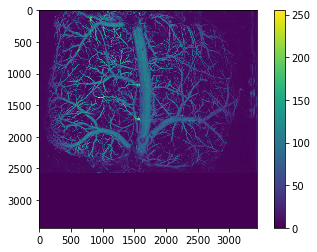

In [28]:
if WHOLEIMG_MODE:
    im_out_ts = norm_uint8(im_out)
    print(im_out_ts.shape)
    im_mask_ts = norm_uint8(im_all[PAD_SIZE:-PAD_SIZE, PAD_SIZE:-PAD_SIZE, 0]*255)
    print(im_mask_ts.shape)
    im_gt_ts = np.zeros(im_out_ts.shape)
    im_ts = np.dstack((im_mask_ts, im_out_ts, im_gt_ts))
    plt.imshow(im_out_ts)
    plt.colorbar()
    plt.show()

In [29]:
if WHOLEIMG_MODE and SAVE_OUTPUT:
    cv2.imwrite(imgpath + '/output/output_brain_xiaoyi/' + imgname + '_dip_out.png', im_ts)   

In [10]:
# For examining noise regularization
if BATCH_MODE:
    count = 1
    for f in list_file:        
        if count < start_count:
            count = count + 1
            continue
            
        print('Current count: ' + str(count))
        print(f)
        
        imgname, imgsuffix = f.split('.')
        if imgsuffix != 'png':
            continue
        
        try:
            im = cv2.imread(imgpath + imgname + '.' + imgsuffix)
            im = im[round(im.shape[0]/2)-150:round(im.shape[0]/2)+150, round(im.shape[1]/2)-150:round(im.shape[1]/2)+150, :]
            im, im_gt, im_masked, im_mask, im_down, factor, _, _ = readImg(im)
            [sr_image, l, model, totalTrainingTimeHr, input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000,
                                                                                 noise_reg=0.07)

            sr_image = np.squeeze(sr_image)
            im_out = np.dstack((im_mask, sr_image, im_gt))
        except:
            continue
                
        
        if SAVE_MODEL:
            model.save(imgpath + '/output_8/' + imgname + '.h5')
            inputNoise = np.squeeze(input_noise)
            inputNoise = inputNoise.reshape((inputNoise.shape[0], 
                                             inputNoise.shape[1]*inputNoise.shape[2]))
            np.savetxt(imgpath + '/output_8/' + imgname + '_inputNoise.txt', 
                       np.asarray(np.squeeze(inputNoise)))
        if SAVE_OUTPUT:
            cv2.imwrite(imgpath + '/output_8/' + imgname + '_dip_out.png', im_out)
            np.savetxt(imgpath + '/output_8/' + imgname + '_Aux.txt', 
                       np.asarray([totalTrainingTimeHr]))
            
        if SAVE_LOSS:
            np.savetxt(imgpath + '/output_8/' + imgname + '_loss.txt', 
                       np.asarray(l))
#         ssim_rec = np.concatenate((ssim_rec, [[ii, cur_ssim]]), axis=0)
        
        if count < batch_range:
#             del model
            K.clear_session()
#             cuda.select_device(0)
#             cuda.close()
            print('Session cleared.')
        elif count == batch_range:
            break
            
        count += 1
    
print('Done')

Done


In [11]:
im.shape

(1000, 1000, 3)

In [12]:
totalTrainingTimeHr

0.5169526298840841